In [13]:
import numpy as np
from keras.api.ops import *
from keras.api.random import normal
from keras.src.layers import Input, Dense, Lambda, Rescaling, Conv2D, Conv2DTranspose, Flatten, Reshape, Layer
from keras.src.models import Model
import keras.api.ops as ops
import matplotlib.pyplot as plt

In [2]:
input_shape = (224, 224, 3)
intermediate_dim = 512
batch_size = 32
latent_dim = 32
epochs = 300

In [3]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = shape(z_mean)[0]
    dim = shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = normal(shape=(batch, dim))
    return z_mean + exp(0.5 * z_log_var) * epsilon

In [4]:
inputs = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(inputs)
x = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', strides=2, padding='same')(x)
#x = Conv2D(256, (3, 3), activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(intermediate_dim, activation='relu', name='fc')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

encoder.summary()

I0000 00:00:1736941478.112555  362276 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2d:00.0, compute capability: 8.6


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        896 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100352)    │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc (Dense)          │ (None, 512)       │ 51,380,736 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 32)        │     16,416 │ fc[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 32)        │     16,416 │ fc[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 32)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,506,816 (196.48 MB)

 Trainable params: 51,506,816 (196.48 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dense(28 * 28 * 128, activation='relu', name='decoder_fc')(x)
x = Reshape((28, 28, 128), name='decoder_reshape')(x)
#x = Dense(14 * 14 * 256, activation='relu', name='decoder_fc')(x)
#x = Reshape((14, 14, 256), name='decoder_reshape')(x)
#x = Conv2DTranspose(256, (3, 3), activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
outputs = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

# Define the decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_fc (Dense)              │ (None, 100352)         │    51,480,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_reshape (Reshape)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 56, 56, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 112, 112, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 224, 224, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,738,179 (197.37 MB)

 Trainable params: 51,738,179 (197.37 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
import keras
import tensorflow as tf

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [7]:
# instantiate VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

In [8]:
# Set batch size and image size
image_size = (224, 224)

# Load all images from a root directory without labels
image_files = tf.io.gfile.glob('img/*')  # Get all files in the directory
image_ds = []

# Function to load and preprocess each image
def load_and_preprocess_image(image_path):
    image = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    return keras.preprocessing.image.img_to_array(image) / 255.

for image_path in image_files:
    image_ds.append(load_and_preprocess_image(image_path))

In [9]:
image_ds = np.array(image_ds)

In [10]:
#hist = vae.fit(image_ds, epochs=50, batch_size=batch_size, verbose=0)
hist = vae.fit(image_ds, epochs=epochs, batch_size=batch_size, verbose=0)

2025-01-15 13:44:48.034740: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1806336000 exceeds 10% of free system memory.
2025-01-15 13:44:49.076006: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1806336000 exceeds 10% of free system memory.
I0000 00:00:1736941491.604985  362394 service.cc:148] XLA service 0x7f5894017610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736941491.605034  362394 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-01-15 13:44:51.662247: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736941491.949848  362394 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-15 13:44:53.250221: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Register

In [11]:
def show_history_plot(history_dict):
    rcv = history_dict["reconstruction_loss"]
    klv = history_dict["kl_loss"]
    epch = range(1, len(klv) + 1)
    _, ax = plt.subplots()

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Reconstruction loss")
    ax.plot(epch, rcv, "b", label="Reconstruction loss")
    ax.legend()

    ax1 = ax.twinx()
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("KL loss")
    ax1.plot(epch, klv, "red", label="KL loss")
    ax1.legend()

    plt.title("Training loss")
    plt.show()

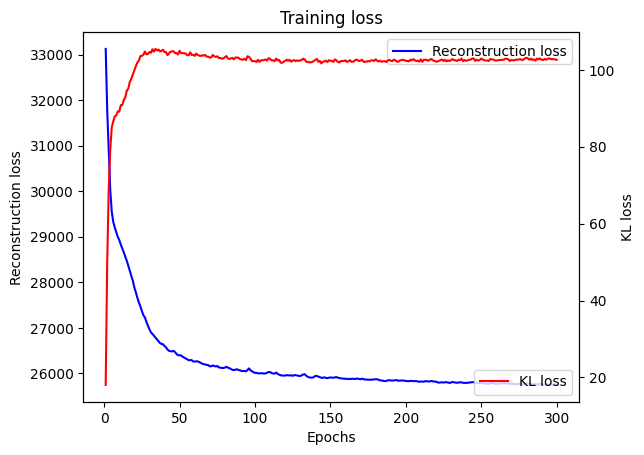

In [14]:
show_history_plot(hist.history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


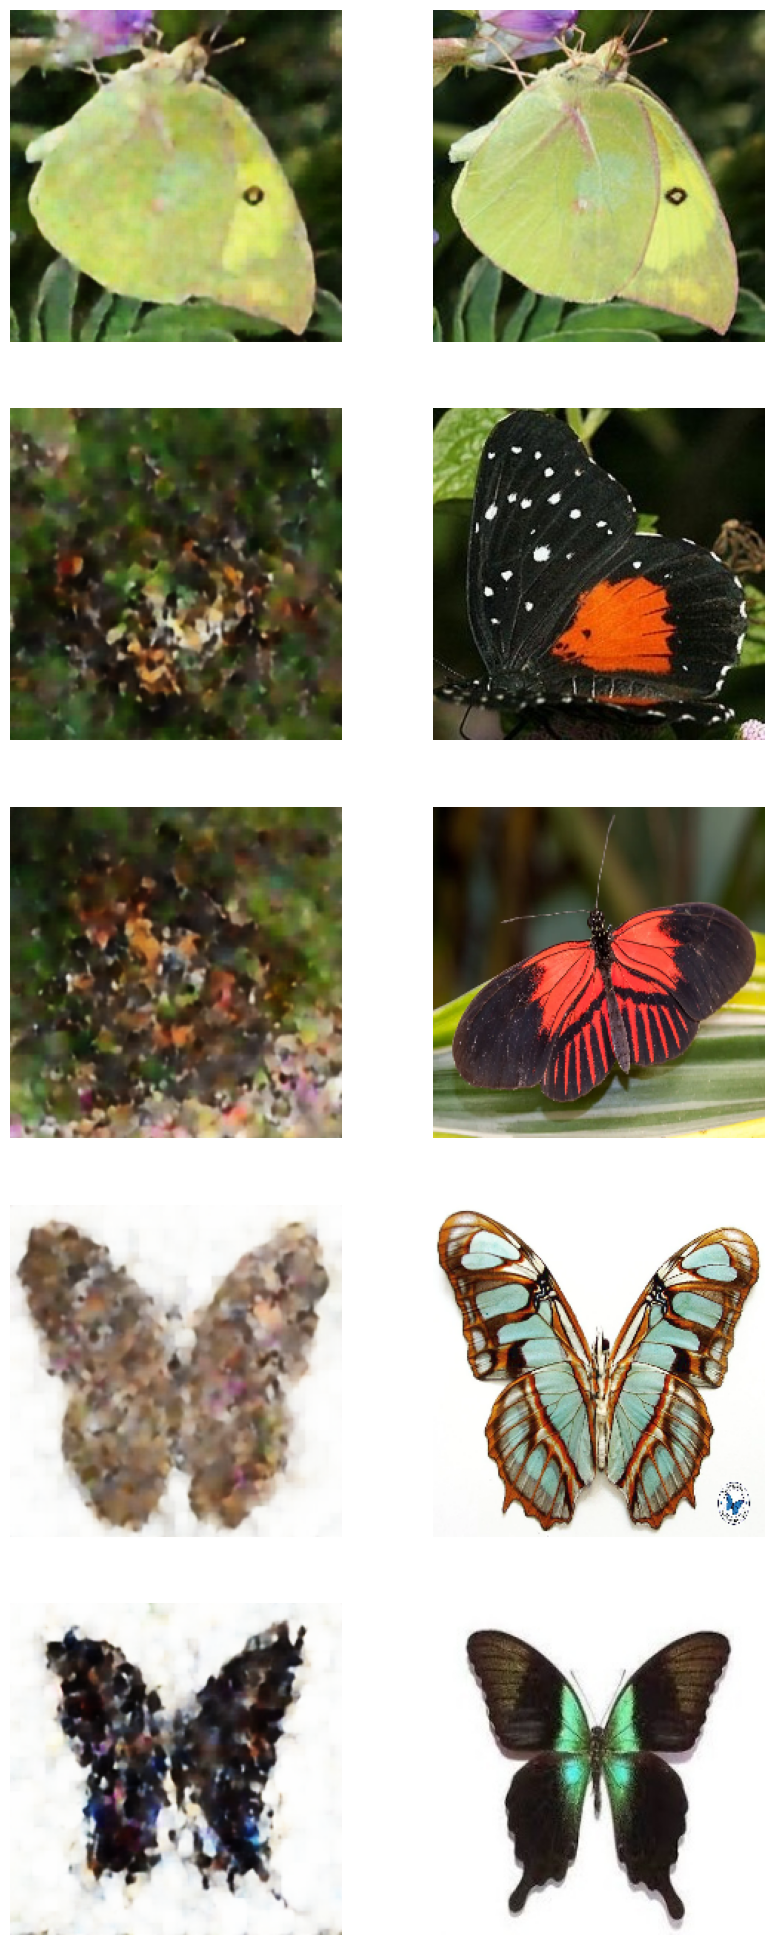

In [21]:
test_image = np.array([
    load_and_preprocess_image("img/Image_1.jpg"),
    load_and_preprocess_image("../lb3/test/Image_2.jpg"),
    load_and_preprocess_image("../lb3/test/img_1.png"),
    load_and_preprocess_image("../lb3/test/img_3.png"),
    load_and_preprocess_image("../lb3/test/Image_122.jpg")
])
_, _, latent = vae.encoder.predict(test_image)
generated_images = vae.decoder.predict(np.array(latent))

generated_images = (generated_images * 255).astype(np.uint8)

# Display the generated images
plt.figure(figsize=(10, 25))
for i in range(len(test_image)):
    plt.subplot(len(test_image), 2, i * 2 + 1)
    plt.imshow(generated_images[i])
    plt.axis("off")
    plt.subplot(len(test_image), 2, (i + 1) * 2)
    plt.imshow(test_image[i])
    plt.axis("off")


### Перший рядок показує, ніскільки якісно проводиться реконструкція зображення, що є в датасеті. Всі інші зображення для моделі не є знайомими. Зі складним фоном генерація дуже погана, а от із суцільним однокольоровим ситуація набагато краща, видно чіткі окреслення метеликів, ще й з особливими ознаками у вигляді подовженої нижньої частини крилець знизу. Датасет складається з 6499 зображень, але ресурси відеокарти дозволили завантажити тільки 3000, а тут, на мою думку, ще важливо робити аугментацію зображень у вигляді поворотів та віддзеркалень.